In [1]:
import pandas as pd
import numpy as np
import glob
import os

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [2]:
def get_meta(path):
    """Returns (threads, num_jsons, repeats)"""
    props = os.path.splitext(os.path.basename(path))[0].split('_')
    values = [int(x[1:]) for x in props[1:]]
    
    return {'max_value':values[0],
            'max_num_values':values[1],
            'threads':values[2],
            'input_size_approx':values[3],
            'repeats':values[4]}

In [3]:
def load(file):
    """Load the experiment data from a CSV file with converter metrics."""
        
    schema = {
        'num_threads': np.int64(),
        'num_jsons_converted': np.int64(),
        'num_json_bytes_converted': np.int64(),
        'num_recordbatch_bytes': np.int64(),
        'num_ipc': np.int64(),
        'ipc_bytes': np.int64(),
        'num_buffers_converted': np.int64(),
        't_parse': np.float64(),
        't_resize': np.float64(),
        't_serialize': np.float64(),
        't_thread': np.float64(),
        't_enqueue': np.float64(),
        'status': np.int64()
    }
    
    df = pd.read_csv(file, dtype=schema)
    
    meta = get_meta(file)

    for key, value in meta.items():  
        df.insert(0, key, value)
        
    # Make sure there were no errors for converters.
    assert(df['status'].sum() == len(df.index))
        
    return df

In [4]:
def analyze(df):
    """Analyze the experiment data, deriving various metrics such as throughput."""
    # Calculate time spent within the thread as 'other'.
    df['t_other'] = df['t_thread'] - df[['t_parse', 't_resize', 't_serialize', 't_enqueue']].sum(axis=1)
    
    # Calculate the throughput per thread
    df['Parse throughput (in)'] = df['num_json_bytes_converted'] / df['t_parse']
    df['Parse throughput (out)'] = df['num_recordbatch_bytes'] / df['t_parse']
    
    return df

In [5]:
def aggr_counts(digit_counts):
    total = 0
    for n, d in digit_counts:
        total = total + n    
    return total
            
def avg_number_of_decimals(max_value):
    ''' Return avg number of decimals of uniform random numbers from 0 up to max_value. '''
    digits = 1
    digit_counts = []
    while (pow(10, digits) < max_value):
        nums = pow(10,digits) - aggr_counts(digit_counts)
        digit_counts.append((nums, digits))
        digits = digits + 1

    digit_counts.append((max_value - aggr_counts(digit_counts), digits))
    
    avg_num_digits = 0
    for n, d in digit_counts:
        avg_num_digits += n/max_value * d
        # print("{} nums with {} digits".format(n, d))
        
    return avg_num_digits

In [97]:
def summarize(df):
    """Summarize the data from one run into one row with averages."""
    
    assert(len(pd.unique(df['max_value'])==1))
    assert(len(pd.unique(df['max_num_values'])==1))
    assert(len(pd.unique(df['threads'])==1))
    assert(len(pd.unique(df['input_size_approx'])==1))
    assert(df['num_threads'].sum()==pd.unique(df['threads'])[0])
    repeats = pd.unique(df['repeats'])[0]
    
    # Avg. value bytes per JSON is the average array size (which is half the max, it is uniform random)
    # times the average number of bytes for uniform random numbers between 0 and max value
    max_value = pd.unique(df['max_value'])[0]
    max_num_values = pd.unique(df['max_num_values'])[0]
    value_bytes = avg_number_of_decimals(max_value) * max_num_values / 2
    
    row = {'Max. value': max_value,
           'Max. number of values': max_num_values,
           'Value bytes': value_bytes,
           'Input size': pd.unique(df['input_size_approx'])[0],
           'Repeats': pd.unique(df['repeats'])[0],
           'Threads': df['num_threads'].sum(),
           'JSONs': df['num_jsons_converted'].sum() / repeats,
           'Bytes (in)': df['num_json_bytes_converted'].sum() / repeats,
           'RecordBatch bytes': df['num_recordbatch_bytes'].sum() / repeats,
           'IPC messages': df['num_ipc'].sum() / repeats,
           'IPC bytes': df['ipc_bytes'].sum() / repeats,
           'Buffers converted': df['num_buffers_converted'].sum() / repeats,
           # For time, we use the mean time of all threads.
           'Parse time': df['t_parse'].mean(),
           'Resize time': df['t_resize'].mean(),
           'Serialize time': df['t_serialize'].mean(),
           'Enqueue time': df['t_enqueue'].mean(),
           'Other time': df['t_other'].mean(),
           'Thread time': df['t_thread'].mean(),
           'Parse throughput (in)': df['num_json_bytes_converted'].sum() / df['t_parse'].max(),
           'Parse throughput (out)': df['num_recordbatch_bytes'].sum() / df['t_parse'].max()}
              
    return row;

In [98]:
def get_all_data(data_path, schema, impl):
    path = '{}/{}/latency/threads/metrics/{}/'.format(data_path, schema, impl)
    csv_files = []
    for file in glob.glob("{}*.csv".format(path)):
        csv_files.append(file)
    print("Found {} files in {}".format(len(csv_files), path))

    records = []
    for file in csv_files:
        records.append(summarize(analyze(load(file))))


    df = pd.DataFrame.from_records(records)
    df.sort_values(by=['Threads', 'JSONs'], inplace=True)
    df.insert(0,'Implementation', impl)
    
    return df

In [99]:
def get_max_throughput_for_max_size(df):
    df = df[df.JSONs == df.JSONs.max()]
    #df.set_index('Threads', inplace=True)

    result = df[df['Parse throughput (in)'] == df['Parse throughput (in)'].max()]

    return result

In [100]:
import matplotlib.pyplot as plt
from utils import lighten_color

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 14
})

colors = ['#4878d0', '#6acc64', '#d65f5f', '#d5bb67', '#dc7ec0', '#8c613c']
markers = ['o', 's', 'd']

In [113]:
d_impls = []

d_impls.append(get_all_data('../experiments/data-p9', 'battery', 'arrow'))
d_impls.append(get_all_data('../experiments/data-p9', 'battery', 'custom'))
d_impls.append(get_all_data('../experiments/data-p9', 'battery', 'fpga'))

df = pd.concat(d_impls)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    display(df)

# Get all dimensions for plots
#max_values = pd.unique(df['Max. value'])
#max_num_values = pd.unique(df['Max. number of values'])
value_bytes = np.sort(pd.unique(df['Value bytes']))
input_sizes = np.sort(pd.unique(df['Input size']))
threads = np.sort(pd.unique(df['Threads']))
impls = pd.unique(df['Implementation'])

print("Value bytes    :", value_bytes)
print("Input sizes    :", input_sizes)
print("Threads        :", threads)
print("Impls          :", impls)

Found 1088 files in ../experiments/data-p9/battery/latency/threads/metrics/arrow/
Found 1088 files in ../experiments/data-p9/battery/latency/threads/metrics/custom/
Found 64 files in ../experiments/data-p9/battery/latency/threads/metrics/fpga/


,Implementation,Max. value,Max. number of values,Value bytes,Input size,Repeats,Threads,JSONs,Bytes (in),RecordBatch bytes,IPC messages,IPC bytes,Buffers converted,Parse time,Resize time,Serialize time,Enqueue time,Other time,Thread time,Parse throughput (in),Parse throughput (out)
816,arrow,18446744073709551615,512,4965.802358,131072,8,1,26.0,1.301110e+05,5.098800e+04,1.0,0.0,1.0,0.023792,3.043000e-06,0.000010,0.000019,0.000050,0.023875,4.374876e+07,1.714430e+07
572,arrow,4294967295,512,2493.772617,131072,8,1,46.0,1.300790e+05,9.658000e+04,1.0,0.0,1.0,0.022710,2.634000e-06,0.000008,0.000015,0.000044,0.022780,4.582243e+07,3.402187e+07
802,arrow,65535,512,1236.600900,131072,8,1,84.0,1.308760e+05,1.782040e+05,1.0,0.0,1.0,0.038472,2.729000e-06,0.000010,0.000018,0.000047,0.038549,2.721488e+07,3.705645e+07
499,arrow,255,512,657.568627,131072,8,1,136.0,1.298520e+05,2.875960e+05,1.0,0.0,1.0,0.050663,2.789000e-06,0.000009,0.000018,0.000055,0.050748,2.050427e+07,4.541282e+07
811,arrow,18446744073709551615,64,620.725295,131072,8,1,199.0,1.301890e+05,5.076000e+04,1.0,0.0,1.0,0.028852,2.953000e-06,0.000009,0.000015,0.000046,0.028925,3.609893e+07,1.407478e+07
836,arrow,4294967295,64,311.721577,131072,8,1,372.0,1.308840e+05,9.507600e+04,1.0,0.0,1.0,0.024457,3.049000e-06,0.000010,0.000020,0.000047,0.024537,4.281260e+07,3.109968e+07
540,arrow,65535,64,154.575113,131072,8,1,659.0,1.309540e+05,1.695280e+05,1.0,0.0,1.0,0.034942,2.633000e-06,0.000009,0.000019,0.000047,0.035019,2.998228e+07,3.881391e+07
23,arrow,255,64,82.196078,131072,8,1,1027.0,1.310590e+05,2.657760e+05,1.0,0.0,1.0,0.048750,2.721000e-06,0.000009,0.000015,0.000058,0.048835,2.150707e+07,4.361443e+07
361,arrow,18446744073709551615,8,77.590662,131072,8,1,1376.0,1.310240e+05,4.934000e+04,1.0,0.0,1.0,0.027381,2.774000e-06,0.000009,0.000018,0.000103,0.027514,3.828187e+07,1.441589e+07
899,arrow,4294967295,8,38.965197,131072,8,1,2317.0,1.310490e+05,8.272000e+04,1.0,0.0,1.0,0.032162,2.915000e-06,0.000010,0.000019,0.000052,0.032246,3.259763e+07,2.057609e+07


Value bytes    : [1.28431373e+00 2.41523613e+00 4.87064964e+00 9.69883273e+00
 1.02745098e+01 1.93218891e+01 3.89651971e+01 7.75906618e+01
 8.21960784e+01 1.54575113e+02 3.11721577e+02 6.20725295e+02
 6.57568627e+02 1.23660090e+03 2.49377262e+03 4.96580236e+03]
Input sizes    : [    131072   16777216  134217728 2147483648]
Threads        : [  1  11  20  22  33  44  55  66  77  88  99 110 121 132 143 154 165 176]
Impls          : ['arrow' 'custom' 'fpga']


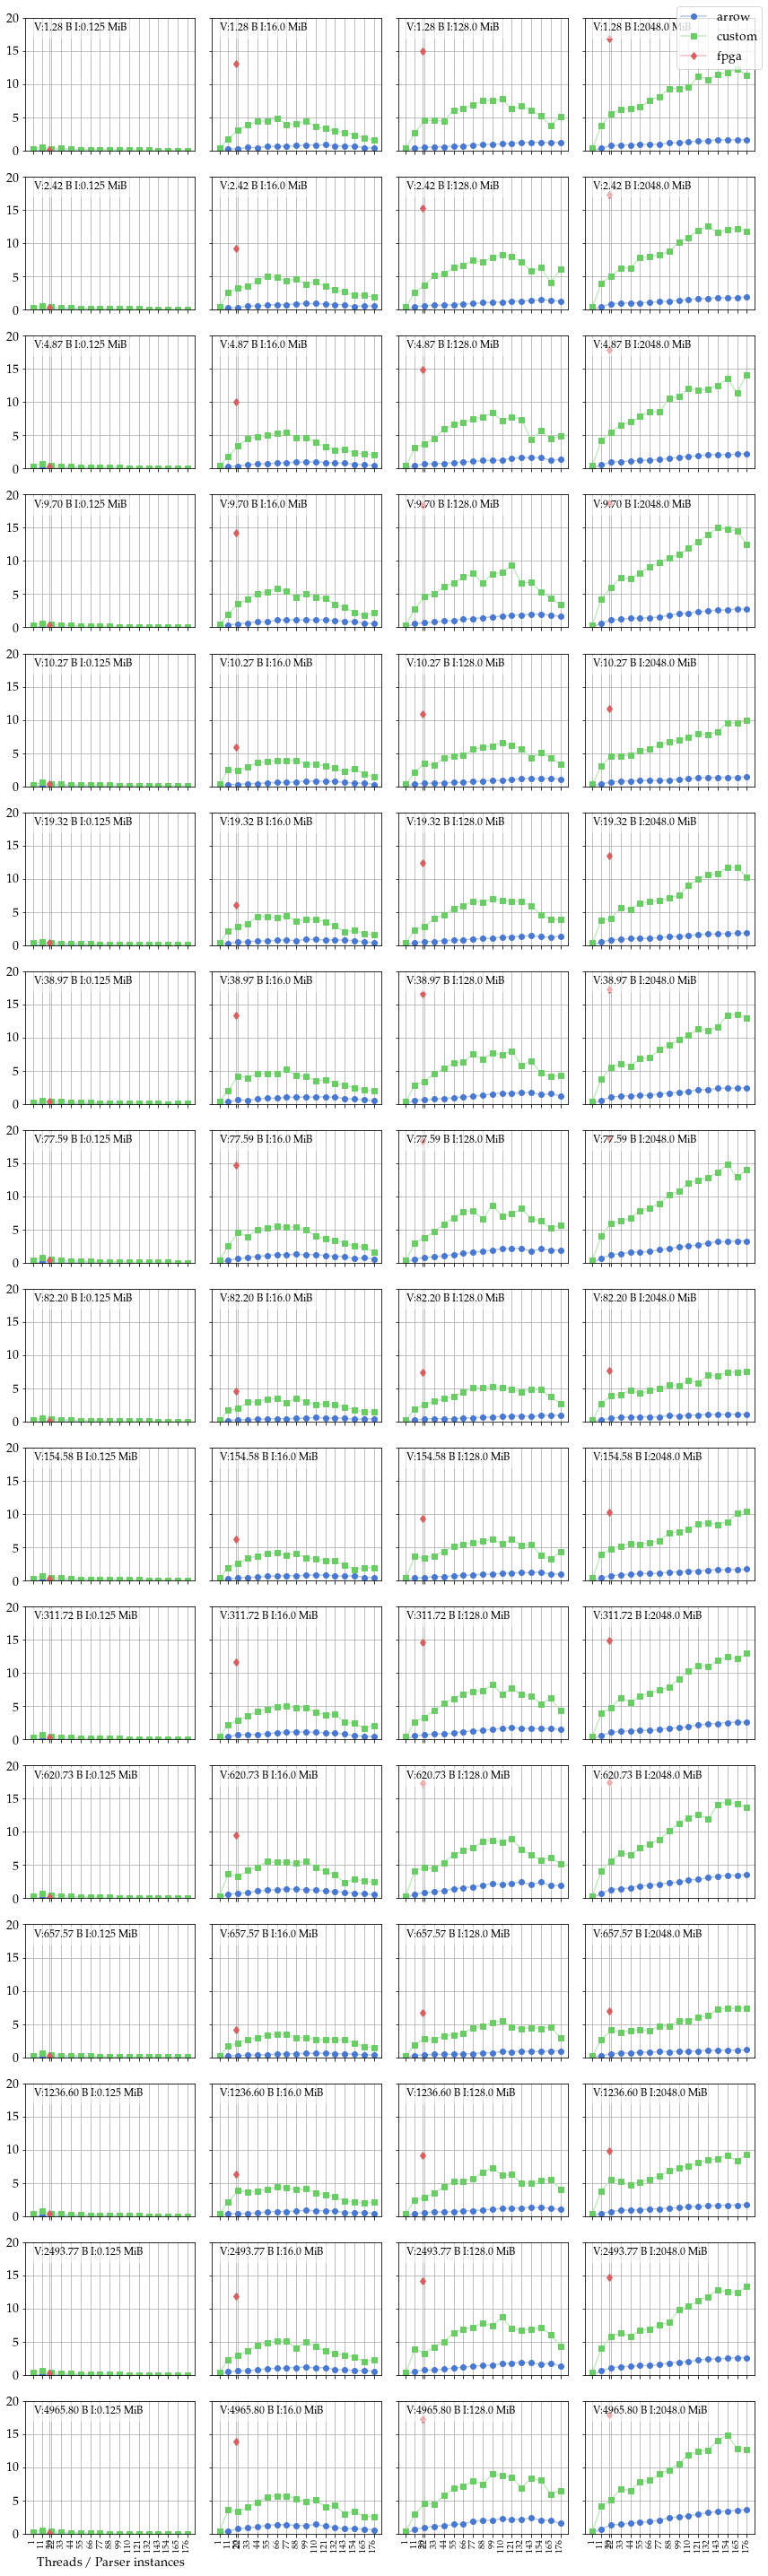

In [111]:
fig, axs = plt.subplots(nrows=len(value_bytes), ncols=len(input_sizes), figsize=(3 * len(input_sizes), 2.5 * len(value_bytes)), sharey=True, sharex=True)

handles = {}

for xa, inps in enumerate(input_sizes):
    for ya, valb in enumerate(value_bytes):
        ax = axs[ya][xa]
                
        for i, impl in enumerate(impls):
            # Prepare plotting data
            dl = df[(df['Value bytes'] == valb) & (df['Input size'] == inps) & (df['Implementation'] == impl)]
            y = dl['Parse throughput (in)'] * 1e-9
            x = dl['Threads']
            
            # Plot data
            handles[impl], = ax.plot(x, y, c=lighten_color(colors[i],0.4), marker=markers[i], mfc=colors[i], mec=colors[i])
            
        # Set inline 
        ax.annotate("V:{:.2f} B I:{} MiB".format(valb, inps / (1<<20)), 
                    xycoords='axes fraction', 
                    xy=(0.05, 0.9), 
                    fontsize=12,
                    backgroundcolor='#FFFFFF80')
        
        ax.set_xticks(threads)
        ax.set_xticklabels(threads, rotation=90, fontsize=10)
        ax.grid(which='both')
        ax.set_ylim(0, 20)
        
        if (ya == len(value_bytes) - 1) and (xa == 0):
            ax.set_xlabel('Threads / Parser instances')

fig.tight_layout()

leg_handles = [v for k,v in handles.items()]
leg_labels = [k for k,v in handles.items()]
fig.legend(leg_handles, leg_labels)